<a href="https://colab.research.google.com/github/Daesere/551Assignments/blob/main/551A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Data acquisition, preprocessing, and exploration

## 1.1 Loading the data

In [4]:
from google.colab import files
uploaded = files.upload()

Saving day.csv to day.csv


In [5]:
import pandas as pd
import io

day_df = pd.read_csv(io.BytesIO(uploaded['day.csv']))


In [6]:
print(day_df.shape[0], day_df.shape[1], day_df.dtypes)

731 16 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


## 1.2 Data cleaning and preprocessing

In [7]:
# Check for missing values (should be none according to dataset website)
check_nan_day = day_df.isnull().values.any()

print(check_nan_day)

False


In [8]:
# Drop IDs
day_df.drop('instant', axis=1, inplace=True)

# Drop casual and registered (cnt = casual + registered) to prevent data leakage
day_df.drop('casual', axis=1, inplace=True)
day_df.drop('registered', axis=1, inplace=True)

print(day_df)

         dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0    2011-01-01       1   0     1        0        6           0           2   
1    2011-01-02       1   0     1        0        0           0           2   
2    2011-01-03       1   0     1        0        1           1           1   
3    2011-01-04       1   0     1        0        2           1           1   
4    2011-01-05       1   0     1        0        3           1           1   
..          ...     ...  ..   ...      ...      ...         ...         ...   
726  2012-12-27       1   1    12        0        4           1           2   
727  2012-12-28       1   1    12        0        5           1           2   
728  2012-12-29       1   1    12        0        6           0           2   
729  2012-12-30       1   1    12        0        0           0           1   
730  2012-12-31       1   1    12        0        1           1           2   

         temp     atemp       hum  windspeed   cnt 

In [9]:
# Encode categorical features as one-hot
day_df_cg = day_df.copy(deep=True) # Save copy for plots
day_df = pd.get_dummies(data=day_df, columns=['season', 'yr', 'mnth', 'weekday', 'weathersit'])
print(day_df)

         dteday  holiday  workingday      temp     atemp       hum  windspeed  \
0    2011-01-01        0           0  0.344167  0.363625  0.805833   0.160446   
1    2011-01-02        0           0  0.363478  0.353739  0.696087   0.248539   
2    2011-01-03        0           1  0.196364  0.189405  0.437273   0.248309   
3    2011-01-04        0           1  0.200000  0.212122  0.590435   0.160296   
4    2011-01-05        0           1  0.226957  0.229270  0.436957   0.186900   
..          ...      ...         ...       ...       ...       ...        ...   
726  2012-12-27        0           1  0.254167  0.226642  0.652917   0.350133   
727  2012-12-28        0           1  0.253333  0.255046  0.590000   0.155471   
728  2012-12-29        0           0  0.253333  0.242400  0.752917   0.124383   
729  2012-12-30        0           0  0.255833  0.231700  0.483333   0.350754   
730  2012-12-31        0           1  0.215833  0.223487  0.577500   0.154846   

      cnt  season_1  season

## 1.3 Data visualization and exploratory analysis

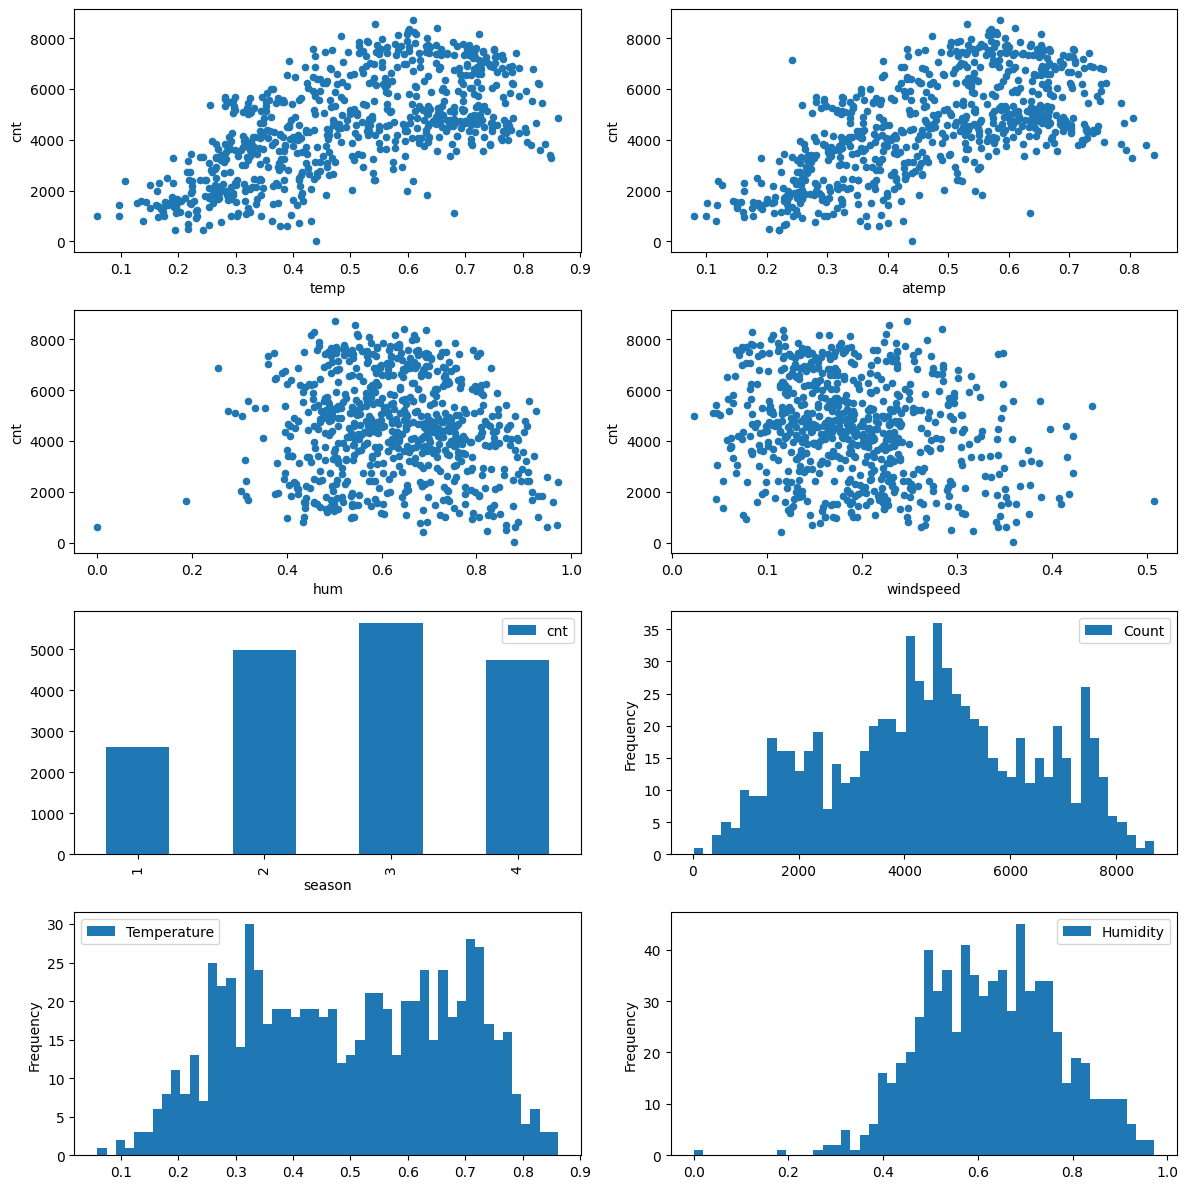

In [23]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

day_df.plot.scatter(x="temp", y="cnt", ax=axs[0, 0])
day_df.plot.scatter(x="atemp", y="cnt", ax=axs[0, 1])
day_df.plot.scatter(x="hum", y="cnt", ax=axs[1, 0])
day_df.plot.scatter(x="windspeed", y="cnt", ax=axs[1, 1])

day_df_cg.groupby("season", as_index=False)["cnt"].mean() \
    .plot.bar(x="season", y="cnt", ax=axs[2, 0])

day_df["cnt"].plot.hist(ax=axs[2, 1], bins=50, label="Count").legend()

day_df["temp"].plot.hist(ax=axs[3, 0], bins=50, label="Temperature").legend()

day_df["hum"].plot.hist(ax=axs[3, 1], bins=50, label="Humidity").legend()

plt.tight_layout()
plt.show()


# Task 2: Linear regression (analytic solution)

## 2.1 Model implementation

In [24]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(1234)

In [25]:
class LinearRegression:
  def __init__(self, add_bias=True):

    self.add_bias = add_bias
    return

  def fit(self, x, y):
    if x.ndim == 1:
        x = x[:, None]

    N = x.shape[0]

    if self.add_bias:
        x = np.column_stack([x, np.ones(N)])

    self.w = np.linalg.lstsq(x, y, rcond=None)[0]

    return self

  def predict(self, x):

    if self.add_bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    yh = x @ self.w

    return yh

  def MSE(self, y, yh):
    return np.mean((y - yh) ** 2)


In [26]:
import copy
day_df_fe = copy.deepcopy(day_df)

def feature_engineer(X, poly=False, interaction=False, log=False):
  features = [X]
  if poly:
    features.append(X ** 2)

  if interaction:
    D = X.shape[1]
    for i in range(D):
        for j in range(i+1, D):
            interaction = (X[:, i] * X[:, j]).reshape(-1, 1)
            features.append(interaction)

  if log:
    features.append(np.log(X + 1))

  return np.column_stack(features)


Train MSE before fe: 2244485.72
Test MSE before fe: 2382439.88
Train MSE after fe: 2025852.69
Test MSE after fe: 2143310.07


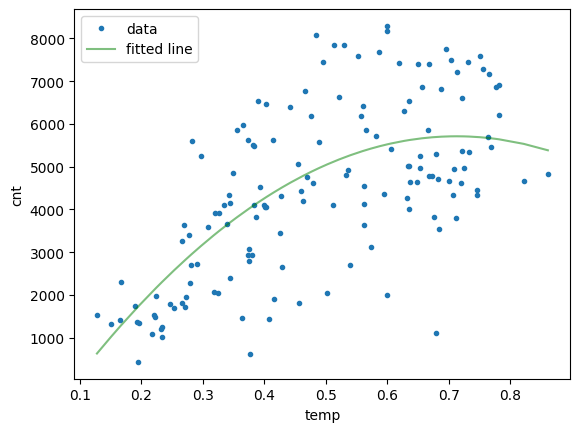

Train MSE before fe: 3692635.81
Test MSE before fe: 3795944.70
Train MSE after fe: 3476661.32
Test MSE after fe: 3390876.97


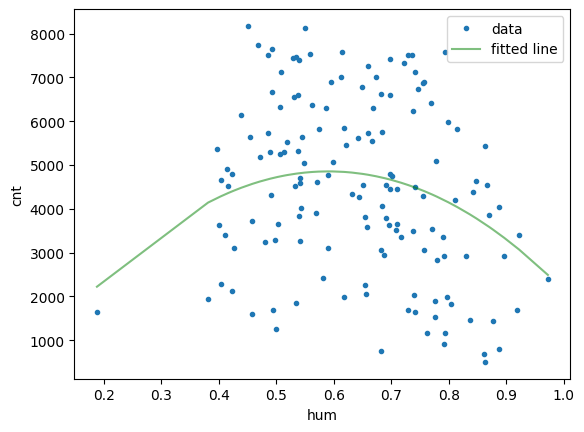

Train MSE before fe: 2654201.75
Test MSE before fe: 2182749.65
Train MSE after fe: 2654201.75
Test MSE after fe: 2182749.65


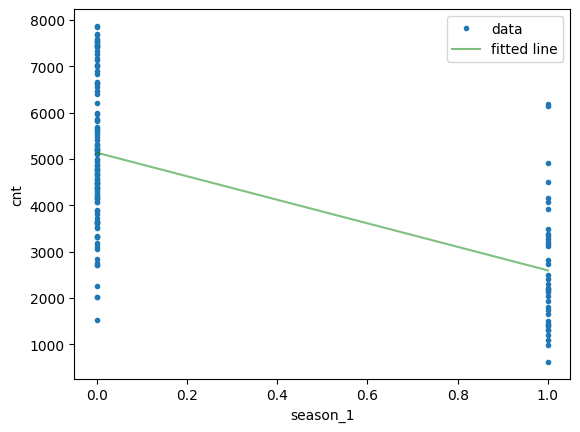

In [32]:
from sklearn import model_selection
def graph(df, x_labels, y_labels, poly=False, interaction=False, log=False):
  x, y = df[x_labels].values, day_df[y_labels].values

  x_train, x_test, y_train, y_test = model_selection.train_test_split(
      x, y, test_size=0.2
  )

  x_train_eng = feature_engineer(x_train, poly, interaction, log)
  x_test_eng = feature_engineer(x_test, poly, interaction, log)

  model = LinearRegression()

  model.fit(x_train, y_train)
  yh_train = model.predict(x_train)
  yh_test = model.predict(x_test)
  print(f"Train MSE before fe: {model.MSE(y_train, yh_train):.2f}")
  print(f"Test MSE before fe: {model.MSE(y_test, yh_test):.2f}")

  model.fit(x_train_eng, y_train)
  yh_train = model.predict(x_train_eng)
  yh_test = model.predict(x_test_eng)
  print(f"Train MSE after fe: {model.MSE(y_train, yh_train):.2f}")
  print(f"Test MSE after fe: {model.MSE(y_test, yh_test):.2f}")

  if x.shape[1] == 1:  # Single feature
    sort_idx = np.argsort(x_test[:, 0])
    x_test_sorted = x_test[sort_idx]
    y_test_sorted = y_test[sort_idx]
    yh_test_sorted = yh_test[sort_idx]

    plt.plot(x_test_sorted, y_test_sorted, '.', label='data')
    plt.plot(x_test_sorted, yh_test_sorted, 'g-', alpha=.5, label='fitted line')
    plt.xlabel(x_labels[0] if isinstance(x_labels, list) else x_labels)
    plt.ylabel(y_labels[0] if isinstance(y_labels, list) else y_labels)
    plt.legend()
    plt.show()
  else:
    print("Plotting skipped: multiple features")
graph(day_df, ["temp"], ["cnt"], poly=True)
graph(day_df, ["hum"], ["cnt"], poly=True)
graph(day_df, ["season_1"], ["cnt"], poly=True)